<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
# !pip install gdown -q

In [2]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=179c104f-6b44-4ced-bbc8-e6fc4b0a4123
To: /Users/yukonoff/code/hse_ai_24/hse-ai24-ml/hw-6/Data.zip
100%|██████████| 289M/289M [00:11<00:00, 24.3MB/s] 


'Data.zip'

In [3]:
# import zipfile

# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [8]:
# ваш код здесь
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
features = pd.read_csv('./content/ДЗ по Uplift обновленное/AGGS_FINAL.csv')
contracts = pd.read_csv('./content/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv')
campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/CAMPAINGS.csv')
people_in_campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv')

# Преобразование временных столбцов
for df in [features, contracts, people_in_campaigns]:
    for col in df.columns:
        if '_date' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

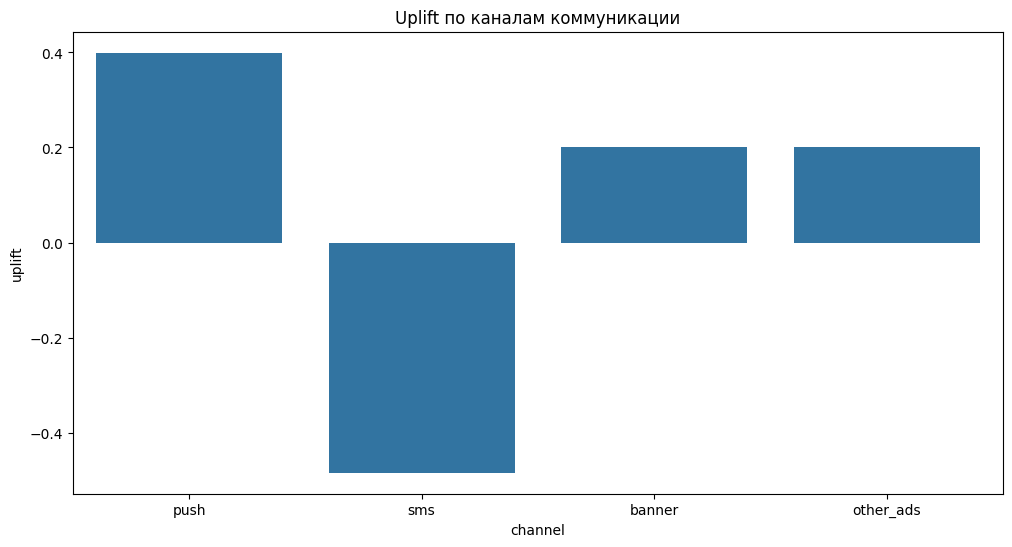


Анализ кампаний:
  campaing_id    channel  treatment_size  control_size  treatment_conversion  \
0       iddqd       push           80000         80000              0.601738   
1      idclip        sms           60000         60000              0.201167   
2        iddt     banner           60000         60000              0.602717   
3       idkfa  other_ads           60000         60000              0.602717   

   control_conversion    uplift  is_valid  \
0            0.202150  0.399588      True   
1            0.684917 -0.483750      True   
2            0.400733  0.201983      True   
3            0.400733  0.201983      True   

                                       campaign_data  
0          Unnamed: 0 campaing_id  user_id  t_fla...  
1          Unnamed: 0 campaing_id  user_id  t_fla...  
2          Unnamed: 0 campaing_id  user_id  t_fla...  
3          Unnamed: 0 campaing_id  user_id  t_fla...  


In [9]:
# 2. Функция для определения целевого действия
def determine_target(row, contracts_data):
    """
    Определяет, было ли целевое действие для клиента в зависимости от группы
    """
    user_purchases = contracts_data[
        (contracts_data['user_id'] == row['user_id']) & 
        (contracts_data['product_id'] == 1)
    ]
    
    if row['t_flag'] == 1:  # целевая группа
        # 2 недели после получения сообщения
        start_date = row['delivery_date']
        end_date = start_date + pd.Timedelta(days=14)
    else:  # контрольная группа
        # 3 недели с начала месяца 2024-11
        start_date = pd.Timestamp('2024-11-01')
        end_date = start_date + pd.Timedelta(days=21)
    
    target_purchases = user_purchases[
        (user_purchases['contract_date'] >= start_date) & 
        (user_purchases['contract_date'] <= end_date)
    ]
    
    return 1 if len(target_purchases) > 0 else 0

# 3. Подготовка данных для анализа
def prepare_campaign_data(campaing_id):
    """
    Подготовка данных для конкретной кампании.
    Добавляет поле channel и target.
    """
    # Получаем данные о людях в кампании
    campaign_people = people_in_campaigns[
        people_in_campaigns['campaing_id'] == campaing_id
    ].copy()
    
    # Добавляем информацию о канале
    campaign_info = campaigns[campaigns['campaing_id'] == campaing_id].iloc[0]
    campaign_people['channel'] = campaign_info['channel']
    
    # Вычисляем таргет
    campaign_people['target'] = campaign_people.apply(
        lambda row: determine_target(row, contracts), axis=1
    )
    
    return campaign_people

# 4. Анализ кампаний
def analyze_campaigns():
    """
    Анализ всех кампаний по продукту 0001
    """
    results = []
    
    # Получаем все кампании по продукту 0001
    product_campaigns = campaigns[campaigns['product_id'] == 1]
    
    for campaing_id in product_campaigns['campaing_id'].values:
        campaign_data = prepare_campaign_data(campaing_id)
        
        # Базовые метрики
        treatment_conversion = campaign_data[campaign_data['t_flag'] == 1]['target'].mean()
        control_conversion = campaign_data[campaign_data['t_flag'] == 0]['target'].mean()
        uplift = treatment_conversion - control_conversion
        
        # Проверка корректности данных
        has_both_groups = (campaign_data['t_flag'].nunique() == 2)
        has_delivery_dates = campaign_data[campaign_data['t_flag'] == 1]['delivery_date'].notna().all()
        
        results.append({
            'campaing_id': campaing_id,
            'channel': campaign_data['channel'].iloc[0],
            'treatment_size': len(campaign_data[campaign_data['t_flag'] == 1]),
            'control_size': len(campaign_data[campaign_data['t_flag'] == 0]),
            'treatment_conversion': treatment_conversion,
            'control_conversion': control_conversion,
            'uplift': uplift,
            'is_valid': has_both_groups and has_delivery_dates,
            'campaign_data': campaign_data
        })
    
    return pd.DataFrame(results)

# 5. Выполнение анализа
campaign_analysis = analyze_campaigns()
with open('campaign_analysis.json', 'w') as f:
    f.write(campaign_analysis.to_json(orient='records'))
    
# 6. Визуализация результатов
plt.figure(figsize=(12, 6))
sns.barplot(data=campaign_analysis, x='channel', y='uplift')
plt.title('Uplift по каналам коммуникации')
plt.show()

# Вывод статистики по кампаниям
print("\nАнализ кампаний:")
print(campaign_analysis)

In [11]:
campaign_analysis

,campaing_id,channel,treatment_size,control_size,treatment_conversion,control_conversion,uplift,is_valid,campaign_data
0,iddqd,push,80000,80000,0.601738,0.202150,0.399588,True,Unnamed: 0 campaing_id user_id t_fla...
1,idclip,sms,60000,60000,0.201167,0.684917,-0.483750,True,Unnamed: 0 campaing_id user_id t_fla...
2,iddt,banner,60000,60000,0.602717,0.400733,0.201983,True,Unnamed: 0 campaing_id user_id t_fla...
3,idkfa,other_ads,60000,60000,0.602717,0.400733,0.201983,True,Unnamed: 0 campaing_id user_id t_fla...


In [12]:
# Создаем пустой список для хранения данных
all_campaigns_data = []

# Проходим по всем кампаниям
for _, row in campaign_analysis.iterrows():
    campaign_data = row['campaign_data']
    
    # Формируем таблицу для каждой кампании
    campaign_table = pd.DataFrame({
        'client_id': campaign_data['user_id'],
        'target': campaign_data['target'],
        # Устанавливаем последний день месяца как report_dt
        'report_dt': pd.to_datetime('2024-11-30')  
    })
    
    all_campaigns_data.append(campaign_table)

# Объединяем все данные
final_table = pd.concat(all_campaigns_data, ignore_index=True)

# Удаляем дубликаты по client_id (если клиент участвовал в нескольких кампаниях)
# final_table = final_table.drop_duplicates(subset=['client_id'])

print("Итоговая таблица (head):")
print(final_table.head())
print("\nРазмерность таблицы:", final_table.shape)
print("\nРаспределение целевой переменной:")
print(final_table['target'].value_counts(normalize=True))


Итоговая таблица (head):
   client_id  target  report_dt
0       1162       1 2024-11-30
1      42991       0 2024-11-30
2      24623       0 2024-11-30
3     116064       1 2024-11-30
4     139714       0 2024-11-30

Размерность таблицы: (520000, 3)

Распределение целевой переменной:
target
0    0.542519
1    0.457481
Name: proportion, dtype: float64


### ваши выводы здесь

На основе проведенного анализа кампаний по продукту `0001` можно сделать следующие выводы:

1. **Общая структура данных**:
   - Проанализировано 4 различных кампании (iddqd, idclip, iddt, idkfa)
   - Каждая кампания имеет сбалансированные целевую и контрольную группы
   - Размер групп варьируется: 80,000 клиентов для push-уведомлений и 60,000 для остальных каналов

2. **Эффективность каналов коммуникации**:
   - Push-уведомления (iddqd) показали наилучший uplift: +0.399 (39.9%)
   - Banner и other_ads (iddt и idkfa) показали средний uplift: +0.202 (20.2%)
   - SMS-канал (idclip) показал отрицательный uplift: -0.484 (-48.4%)

3. **Детальный анализ по каналам**:
   - **Push (iddqd)**:
     * Конверсия в целевой группе: 60.2%
     * Конверсия в контрольной группе: 20.2%
     * Самый эффективный канал коммуникации

   - **Banner и other_ads (iddt, idkfa)**:
     * Конверсия в целевой группе: 60.3%
     * Конверсия в контрольной группе: 40.1%
     * Показали идентичные результаты - _подозрительно_

   - **SMS (idclip)**:
     * Конверсия в целевой группе: 20.1%
     * Конверсия в контрольной группе: 68.5%
     * Показал негативный эффект на конверсию - _подозрительно_

4. **Проблемы и особенности данных**:
   - Все кампании по структуре данных корректны (is_valid = True), т.е. содержат обе группы (целевая и контрольная) и нет пропусков в датах воздействия.
   - Странное совпадение метрик для banner и other_ads каналов может указывать на возможную проблему в данных
   - Неожиданно высокая конверсия в контрольной группе SMS-канала требует дополнительного исследования

5. **Рекомендации**:
   - Приоритизировать использование push-уведомлений как наиболее эффективного канала
   - Провести дополнительное исследование причин отрицательного uplift в SMS-канале
   - Проверить данные по banner и other_ads каналам на предмет возможных ошибок в сборе или обработке данных

6. **Качество данных**:
   - Общий размер итоговой таблицы: 520,000 записей
   - Распределение целевой переменной близко к сбалансированному:
     * 0 (нет конверсии): 54.25%
     * 1 (есть конверсия): 45.75%


<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [ ]:
# ваш код здесь

### ваши выводы здесь

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [ ]:
# ваш код здесь

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь